<a href="https://colab.research.google.com/github/xsinxxer/starters/blob/main/ai_explainability_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0


Epoch 1/10
1563/1563 [==============================] - 14s 8ms/step - loss: 2.1182 - accuracy: 0.2649 - val_loss: 1.7694 - val_accuracy: 0.4006
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.8118 - accuracy: 0.3944 - val_loss: 1.6009 - val_accuracy: 0.4865
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7240 - accuracy: 0.4448 - val_loss: 1.5963 - val_accuracy: 0.4975
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6693 - accuracy: 0.4760 - val_loss: 1.4898 - val_accuracy: 0.5359
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6385 - accuracy: 0.4944 - val_loss: 1.4762 - val_accuracy: 0.5612
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6036 - accuracy: 0.5095 - val_loss: 1.4322 - val_accuracy: 0.5703
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5874 - accuracy: 0.5187 - val_loss: 1.4764 - val_acc

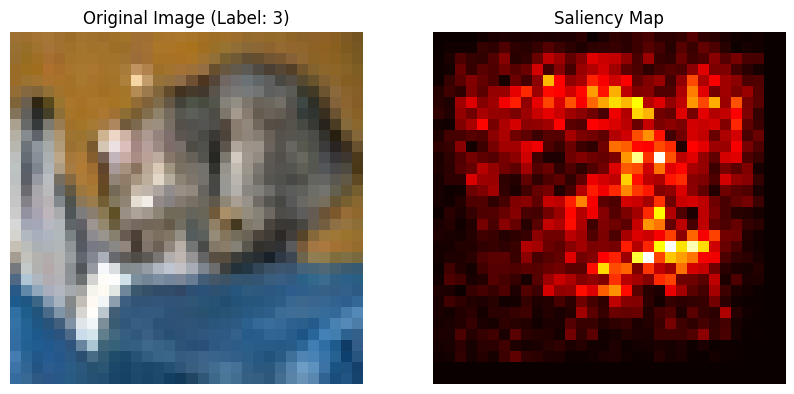

In [22]:
l1_penalty = 0.0001
l2_penalty = 0.0001
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),
                  kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty)),
    layers.Dropout(0.25),
    layers.Flatten(),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty)),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty)),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax',
                 kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty))
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))
def compute_saliency_map(model, img, label):
    img_tensor = tf.convert_to_tensor(img.reshape(1, 32, 32, 3), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = model(img_tensor)
        loss = prediction[0, label]
    gradient = tape.gradient(loss, img_tensor)
    gradient = tf.abs(gradient)
    gradient = tf.reduce_max(gradient, axis=-1)[0]  # Max over color channels
    return gradient.numpy()

# Smoothgrad will help!!!!

#Always try to break down why not working,never give up as you would have!!!!!!!!

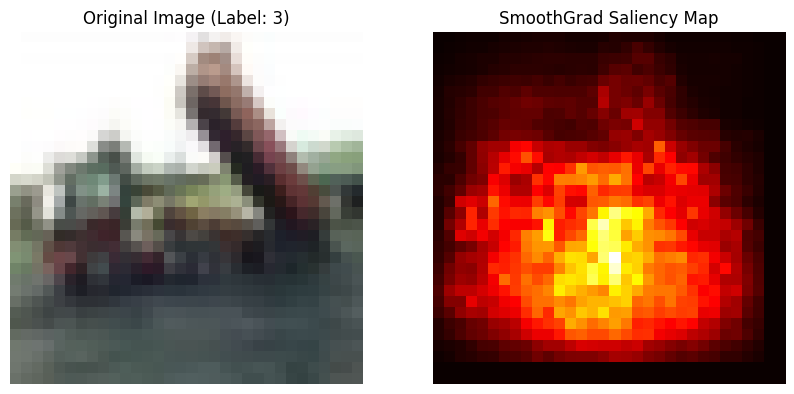

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_smoothgrad_saliency_map(model, img, label, num_samples=50, noise_level=0.1):
    img_tensor = tf.convert_to_tensor(img.reshape(1, 32, 32, 3), dtype=tf.float32)
    saliency_maps = []
    for i in range(num_samples):
        noise = tf.random.normal(shape=img_tensor.shape, mean=0.0, stddev=noise_level)
        noisy_img = img_tensor + noise
        with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            prediction = model(noisy_img)
            loss = prediction[0, label]
        gradient = tape.gradient(loss, noisy_img)
        gradient = tf.abs(gradient)
        gradient = tf.reduce_max(gradient, axis=-1)[0]
        saliency_maps.append(gradient.numpy())
    saliency_map = np.mean(saliency_maps, axis=0)
    return saliency_map
sample_image = x_train[2]
sample_label = y_test[0][0]
smoothgrad_saliency_map = compute_smoothgrad_saliency_map(model, sample_image, sample_label)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Original Image (Label: {sample_label})")
plt.imshow(sample_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("SmoothGrad Saliency Map")
plt.imshow(smoothgrad_saliency_map, cmap='hot')
plt.axis('off')
plt.show()


# l1,l2 really helped huh

# Lets see more resolution images with models; new notebook